In [11]:
library(Seurat, verbose=F)
library(ggplot2, verbose=F)
library(patchwork, verbose=F)
library(magrittr, verbose=F)
library(data.table, verbose=F)
library(ggsci)
#设置当前工作目录
setwd('/Users/wjs/Desktop/github/singlecell_notebooks/')

## 批次效应

##### 批次效应产生的原因
批次效应是指由于处理不同批次的细胞而导致的数据中不必要的技术变化。这些影响可能源于测序深度、读取长度、样品采集和处理、样品成分、采样时间等等，此外，组织、空间位置、个体差异等生物因素也可以视为批次效应。 时空组学数据集通常是包括跨越地点、实验室和条件的样本，从而使其复杂性不断增加，这种复杂性在细胞图谱中会不可避免的产生批次效应。因此，时空组学数据分析的一个重大挑战就是：开发克服这些数据中复杂的、非线性的、嵌套的批次效应的数据集成方法。

##### 标准化与批次效应的差异
值得注意的是，标准化与批次校正之间的不同。标准化是要去除细胞间的技术偏倚，而批次校正是要移除技术偏倚和生物学偏倚，相对于技术偏倚，生物学偏倚是更加不可预测的。另一方面，批次校正算法是允许相同批次的细胞共享信息的，并假定相同批次的细胞受到的批次效应的影响相同，而标准化方法则是逐个细胞进行的，而与细胞之间的信息无关。
标准化和批次效应是不同的任务，要求不同的假设和计算方法，不过它们并不是互斥的，通常的处理流程是在批次内进行标准化，后续再进行批次校正。

##### 去除批次效应的方法
**线性模型**：来自limma包的removeBatchEffect()函数以及来自sva包的comBat()函数，都是基于线性模型的方法。线性模型要求各批次细胞亚群的组成是相同的，批次效应是相加性的，即任何批次诱导的表达折叠变化在任何给定基因的不同细胞亚群中都是相同的。这些都是强有力的假设，因为来自不同个体的批次自然会表现出细胞类型丰度和表达的变化。尽管如此，我们在处理来自同一细胞群的技术重复的批次时，可以认为满足这些假设。事实上，当其假设成立时，线性回归在统计上是最有效的，因为它使用来自所有细胞的信息来计算常见的批次向量。

**互近邻**：不同批次之间存在相同的细胞类型，并且这些细胞类型在各个批次中的表达模式相似。也就是说，如果两个来自不同批次的细胞有相似的表达模式，则这两个细胞很可能是同一类型的细胞。基于这个假设，MNN算法通过比较跨批次的最近邻关系，将不同批次之间的细胞划分为相同的群体，并对这些群体进行批次校正，从而去除批次效应。另外还需要假设是批次效应应该是与生物学效应正交的，通俗的说就是与生物学效应互不相关

去除批次效应的一般性假设条件：
1. 所有批次采样的细胞都来自同一类型的组织或细胞种群。
2. 每个批次内的细胞数量应该在同一数量级，并且各个批次的样本中细胞的比例应该相似。
3. 所有细胞都经过了相同的RNA-Seq实验处理流程和数据预处理流程，如RNA测序深度、基因过滤方式、读写质量控制等。
4. 细胞之间的差异主要是由于生物学原因而不是实验误差或批次效应引起的。

**Harmony**：(A) Harmony使用模糊聚类将每个细胞分配到多个聚类中，同时使用惩罚项确保每个聚类中的多样性最大化。(B) Harmony计算每个聚类的全局质心，以及每个聚类的数据集特定质心。(C) 在每个聚类中，Harmony根据质心计算每个数据集的校正因子。(D) 最后，Harmony使用基于软聚类分配的数据集校正因子的线性组合来校正每个细胞。Harmony重复执行步骤A到D直到收敛。聚类分配和数据集之间的依赖关系会随着每轮迭代而减弱。

<img src="data/figure/harmony.png" style="width:80%;position:relative;left:10%" alt='IMG'>

In [3]:
library(harmony)

Loading required package: Rcpp



In [4]:
#suppressMessages(library(SeuratData, verbose=F))
#InstallData("ifnb")
#ifnb <- LoadData("ifnb")
ifnb <- readRDS('data/ifnb.RDS')

In [5]:
ifnb[["RNA"]] <- split(ifnb[["RNA"]], f = ifnb$stim)

In [6]:
names(ifnb@assays$RNA@layers)

[1] "counts.CTRL" "counts.STIM" "data.CTRL"   "data.STIM"

In [7]:
clustering <- function(sce, res=0.8, prefix=''){
        sce <- NormalizeData(sce, verbose=F) %>%
           FindVariableFeatures(verbose=F) %>%
           ScaleData(verbose = F) %>%
           RunPCA(verbose = F)
        return(sce)
}

In [8]:
ifnb <- clustering(ifnb)

In [9]:
ifnb <- FindNeighbors(ifnb, dims = 1:30, reduction = "pca", verbose=F)
ifnb <- FindClusters(ifnb, resolution = 0.8, cluster.name = "unintegrated_clusters", verbose=F)
ifnb <- RunUMAP(ifnb, dims = 1:30, reduction = "pca", reduction.name = "umap.unintegrated", verbose=F)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


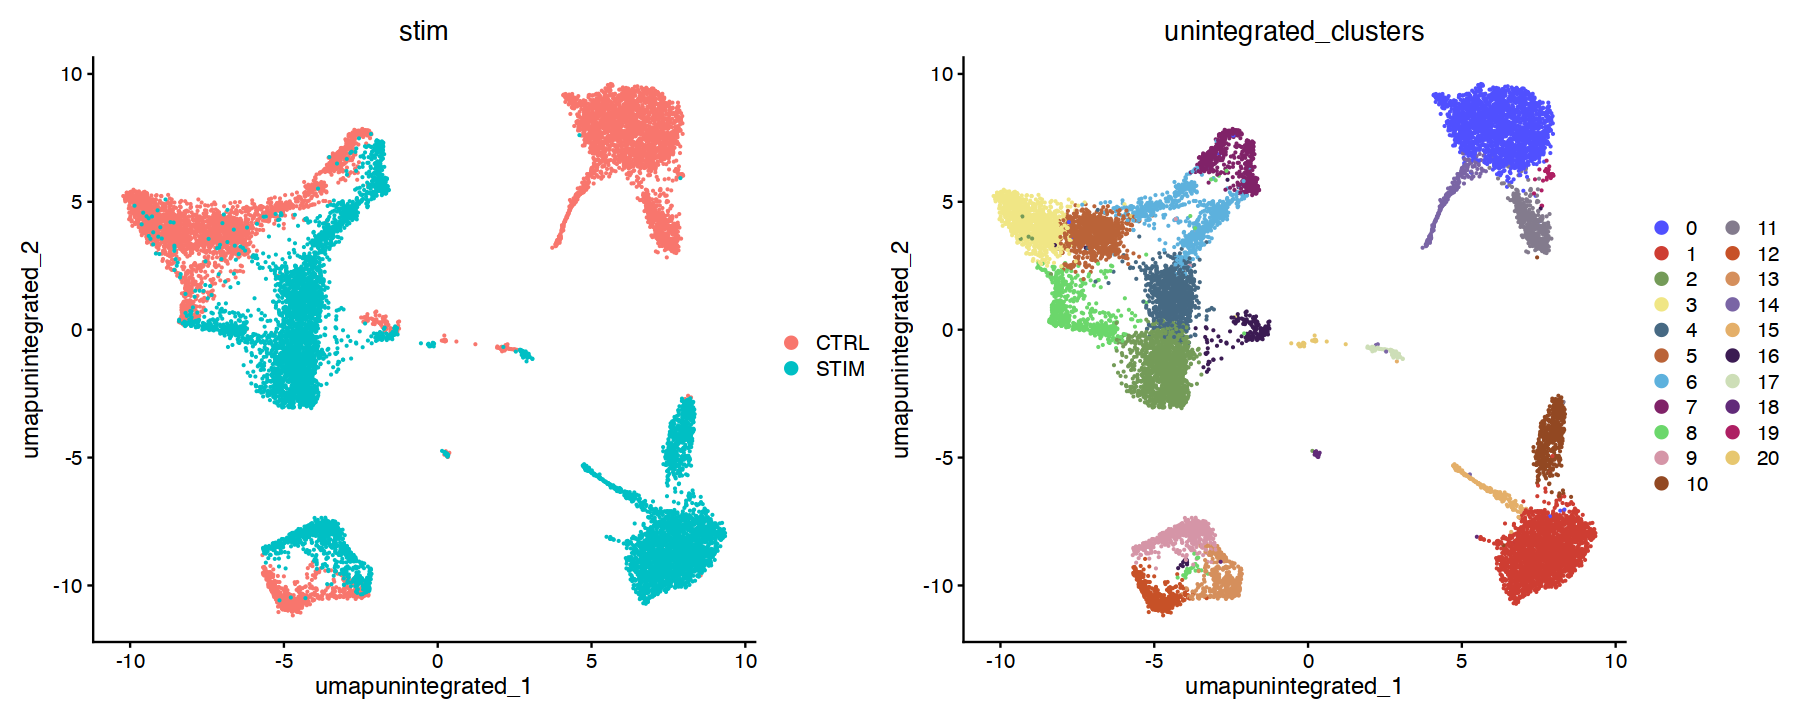

In [12]:
options(repr.plot.width=15, repr.plot.height=6)
DimPlot(ifnb, reduction = "umap.unintegrated", group.by = c("stim", "unintegrated_clusters")) + scale_color_igv()

#### CCA

In [14]:
ifnb <- IntegrateLayers(object = ifnb, method = CCAIntegration, orig.reduction = "pca", 
                        new.reduction = "integrated.cca", verbose = FALSE)

In [15]:
ifnb <- FindNeighbors(ifnb, reduction = "integrated.cca", dims = 1:30)
ifnb <- FindClusters(ifnb, resolution = 0.8, cluster.name='cca_clusters')
ifnb <- RunUMAP(ifnb, dims = 1:30, reduction = "integrated.cca", reduction.name = "umap.cca", verbose=F)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13999
Number of edges: 589215

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8639
Number of communities: 17
Elapsed time: 1 seconds


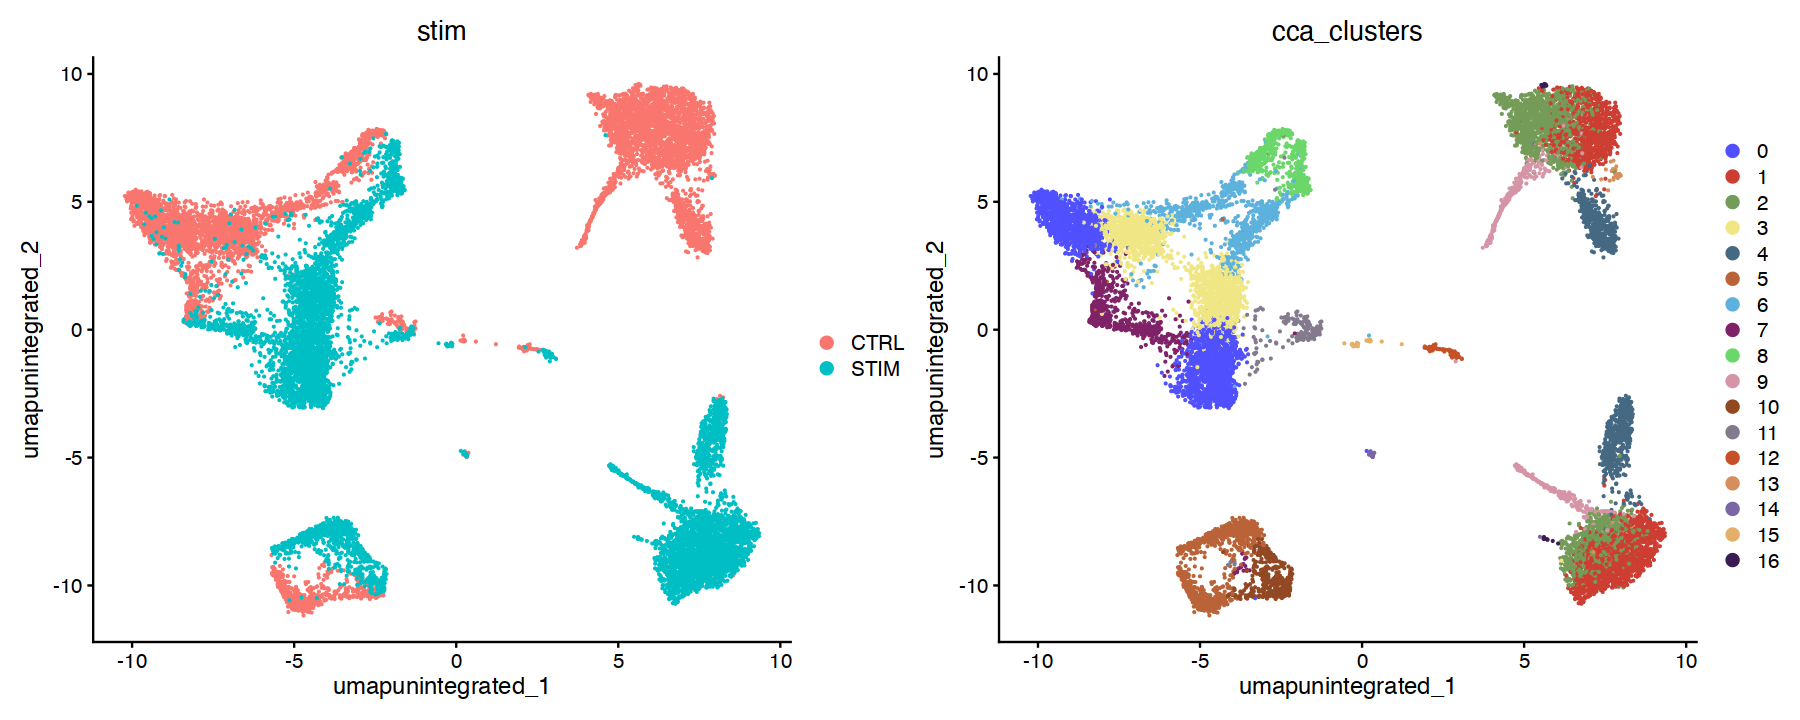

In [16]:
DimPlot(ifnb, reduction = "umap.unintegrated", group.by = c("stim", "cca_clusters")) + scale_color_igv()

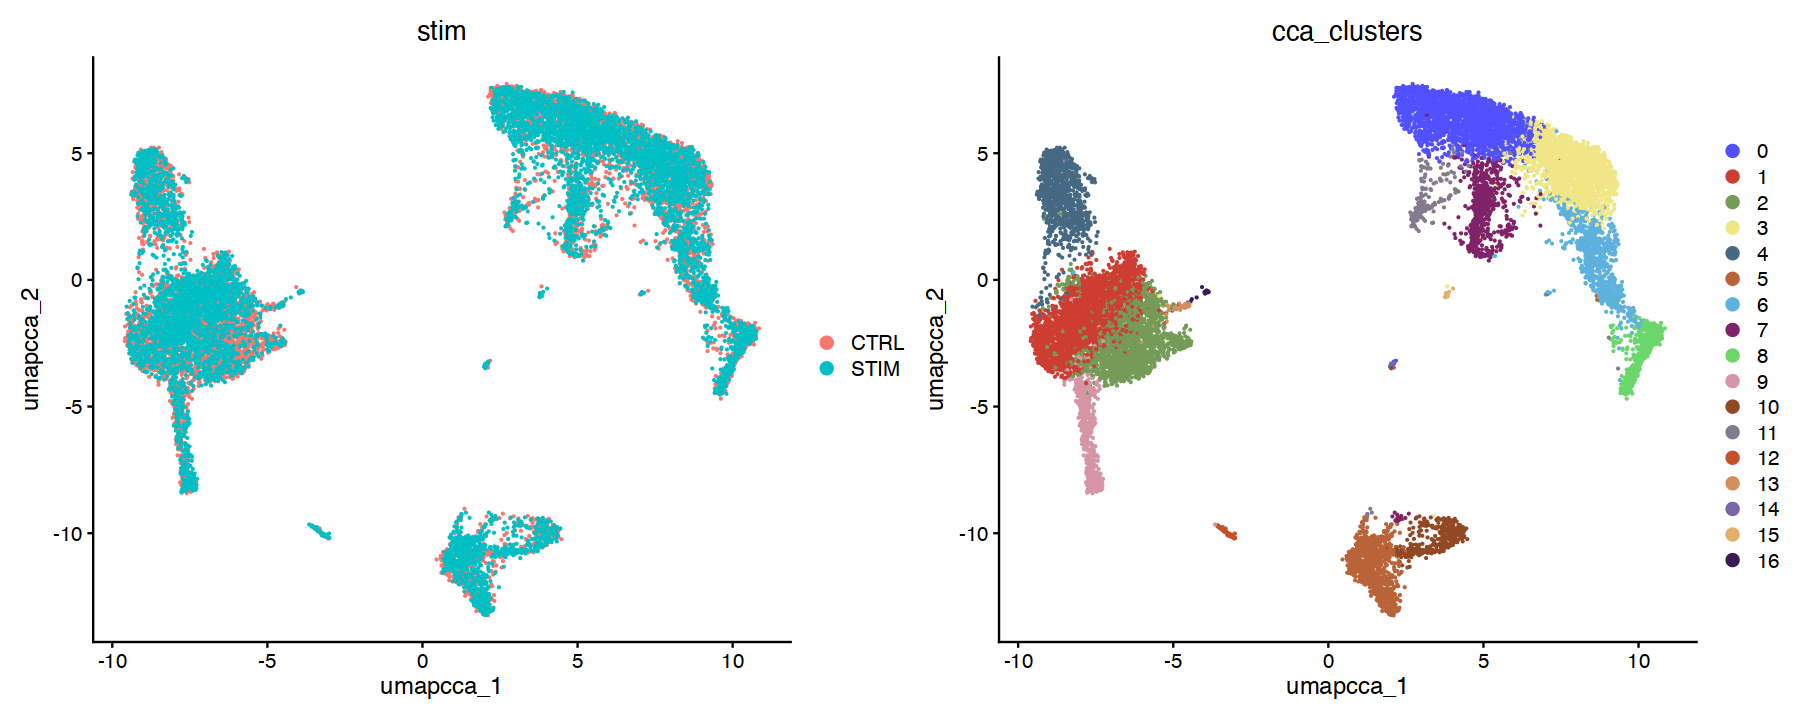

In [17]:
DimPlot(ifnb, reduction = "umap.cca", group.by = c("stim", "cca_clusters")) + scale_color_igv()

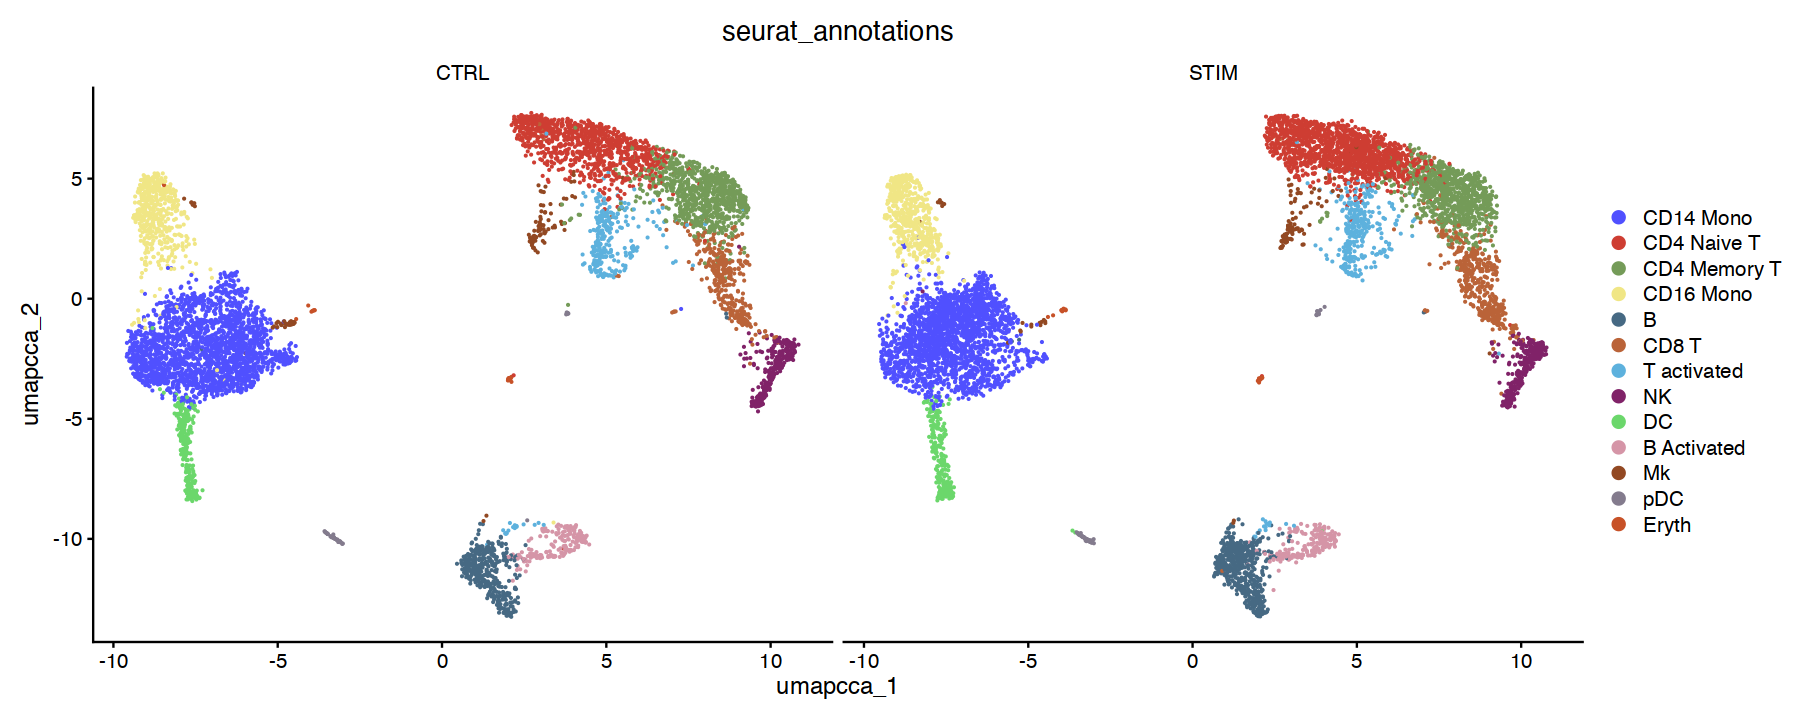

In [18]:
DimPlot(ifnb, reduction = "umap.cca", split.by = "stim", group.by='seurat_annotations') + scale_color_igv()

In [19]:
#ifnb <- IntegrateLayers(
#  object = ifnb, method = RPCAIntegration,
#  orig.reduction = "pca", new.reduction = "integrated.rpca",
#  verbose = FALSE
#)

In [20]:
#ifnb <- IntegrateLayers(
#  object = ifnb, method = FastMNNIntegration,
#  new.reduction = "integrated.mnn",
#  verbose = FALSE
#)

#### harmony

In [21]:
ifnb <- IntegrateLayers(
  object = ifnb, method = HarmonyIntegration,
  orig.reduction = "pca", new.reduction = "harmony",
  verbose = FALSE
)

In [22]:
ifnb <- FindNeighbors(ifnb, reduction = "harmony", dims = 1:30, verbose=F)
ifnb <- FindClusters(ifnb, resolution = 0.8, cluster.name='harmony_clusters', verbose=F)
ifnb <- RunUMAP(ifnb, dims = 1:30, reduction = "harmony", verbose=F, reduction.name = 'umap.harmony')

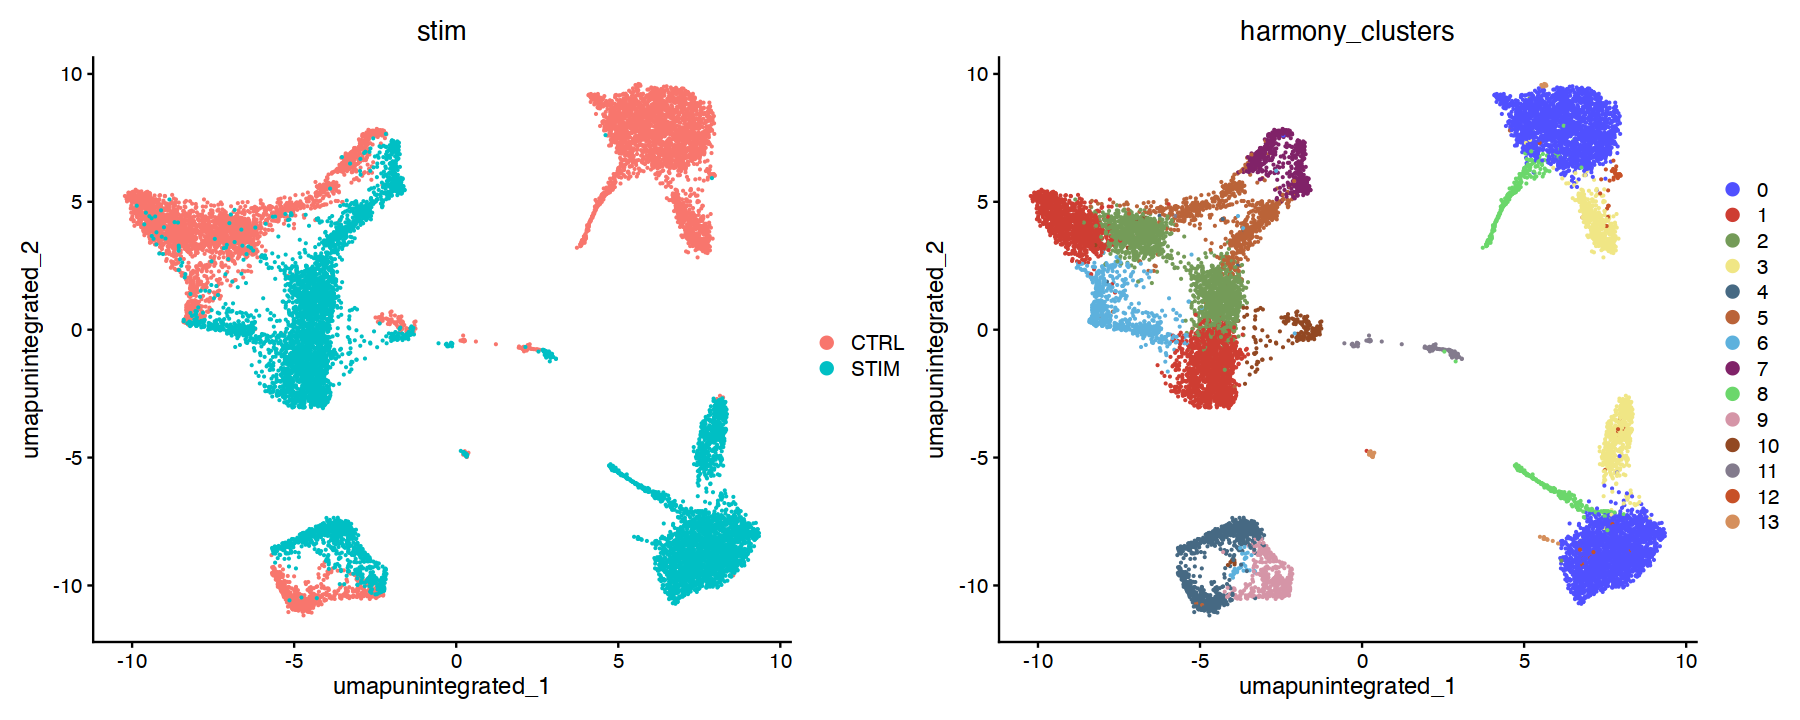

In [23]:
DimPlot(ifnb, reduction = "umap.unintegrated", group.by = c("stim", "harmony_clusters")) + scale_color_igv()

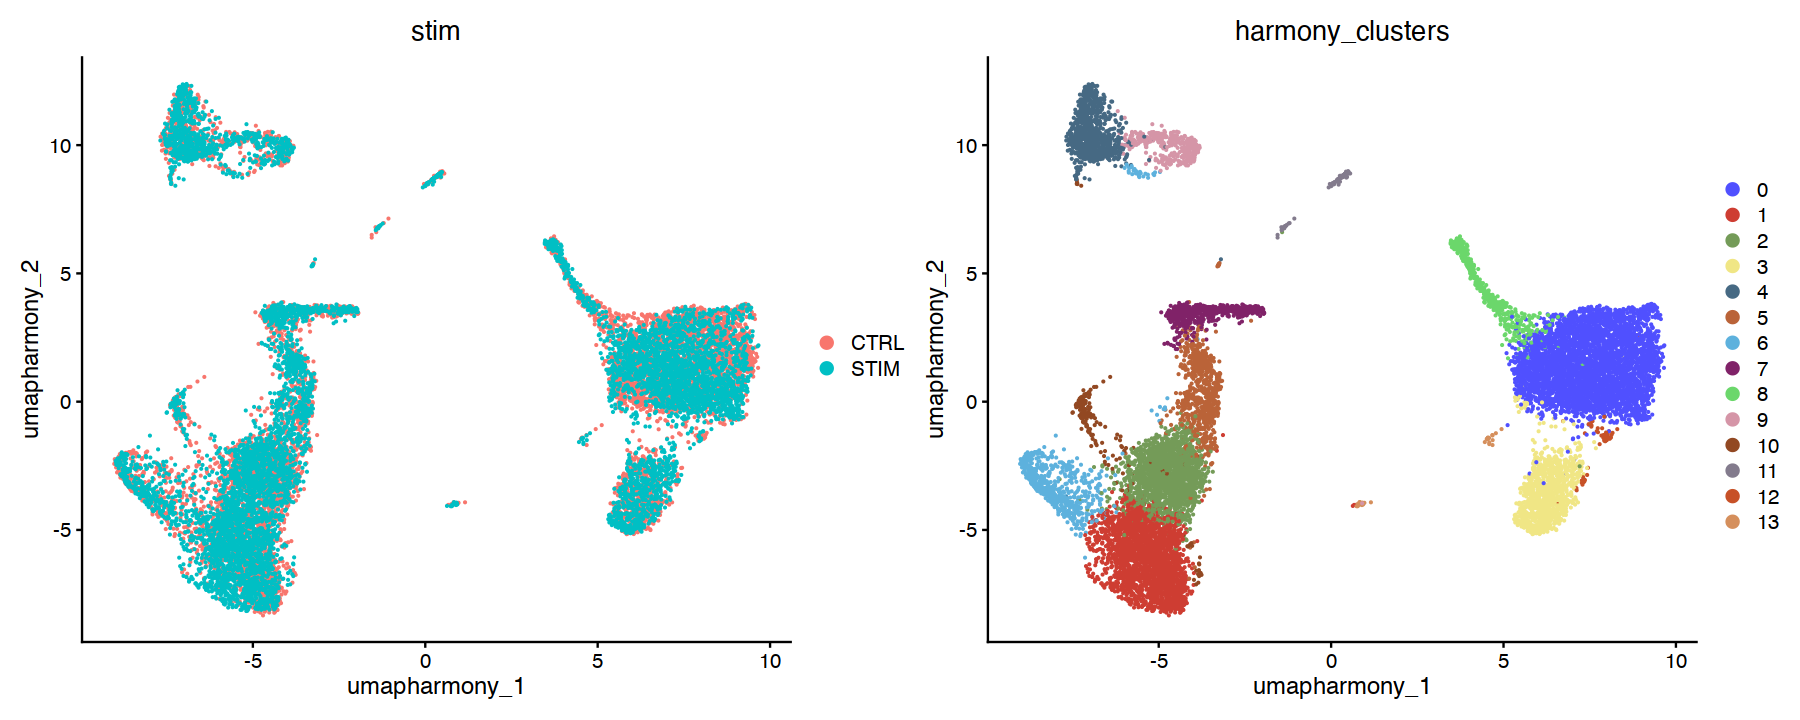

In [24]:
DimPlot(ifnb, reduction = "umap.harmony", group.by = c("stim", "harmony_clusters")) + scale_color_igv()

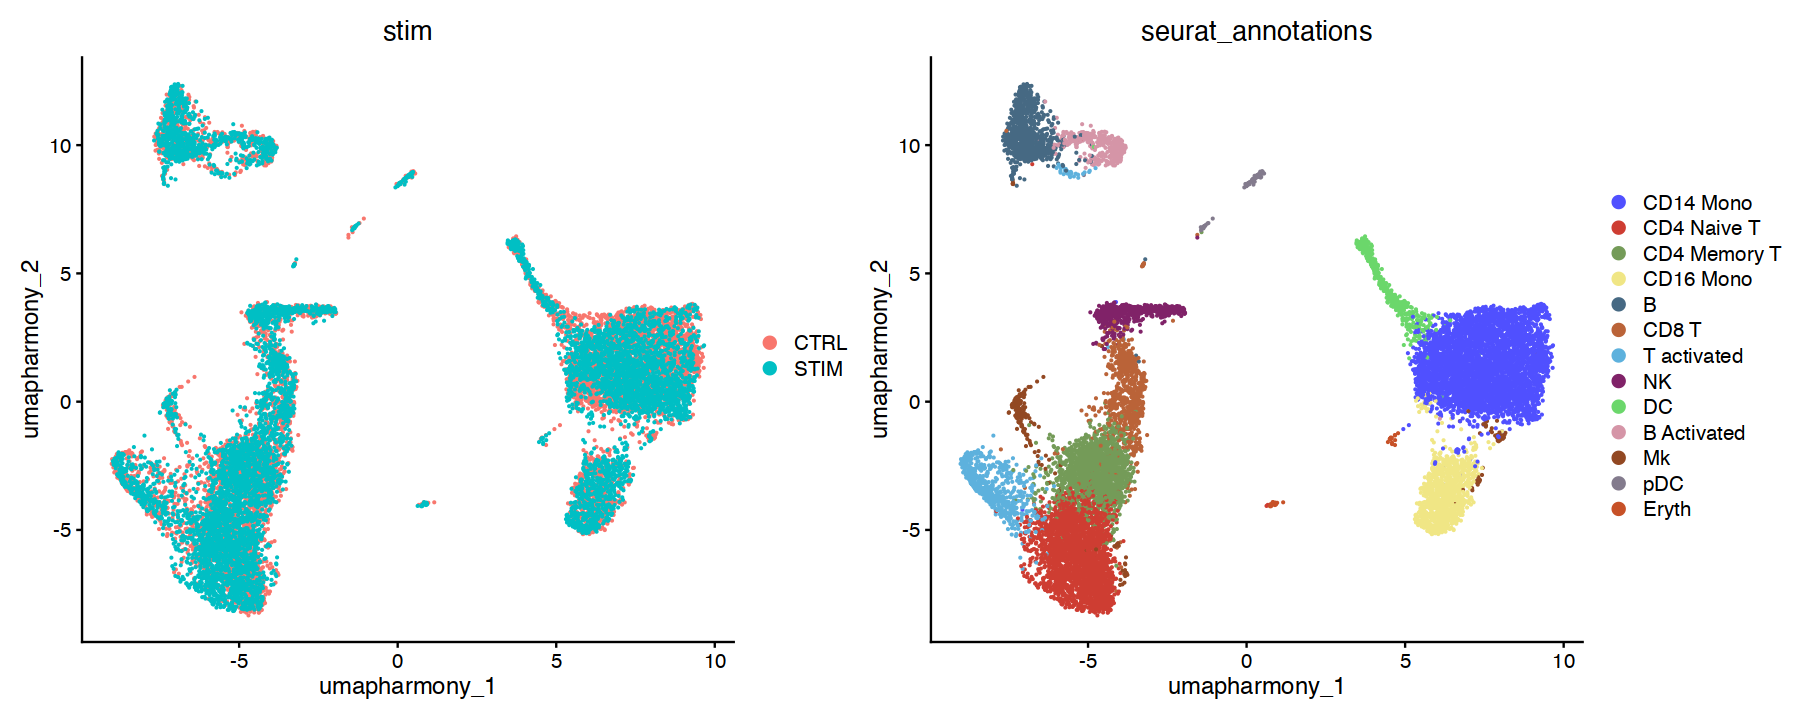

In [25]:
DimPlot(ifnb, reduction = "umap.harmony", group.by = c("stim", "seurat_annotations")) + scale_color_igv()

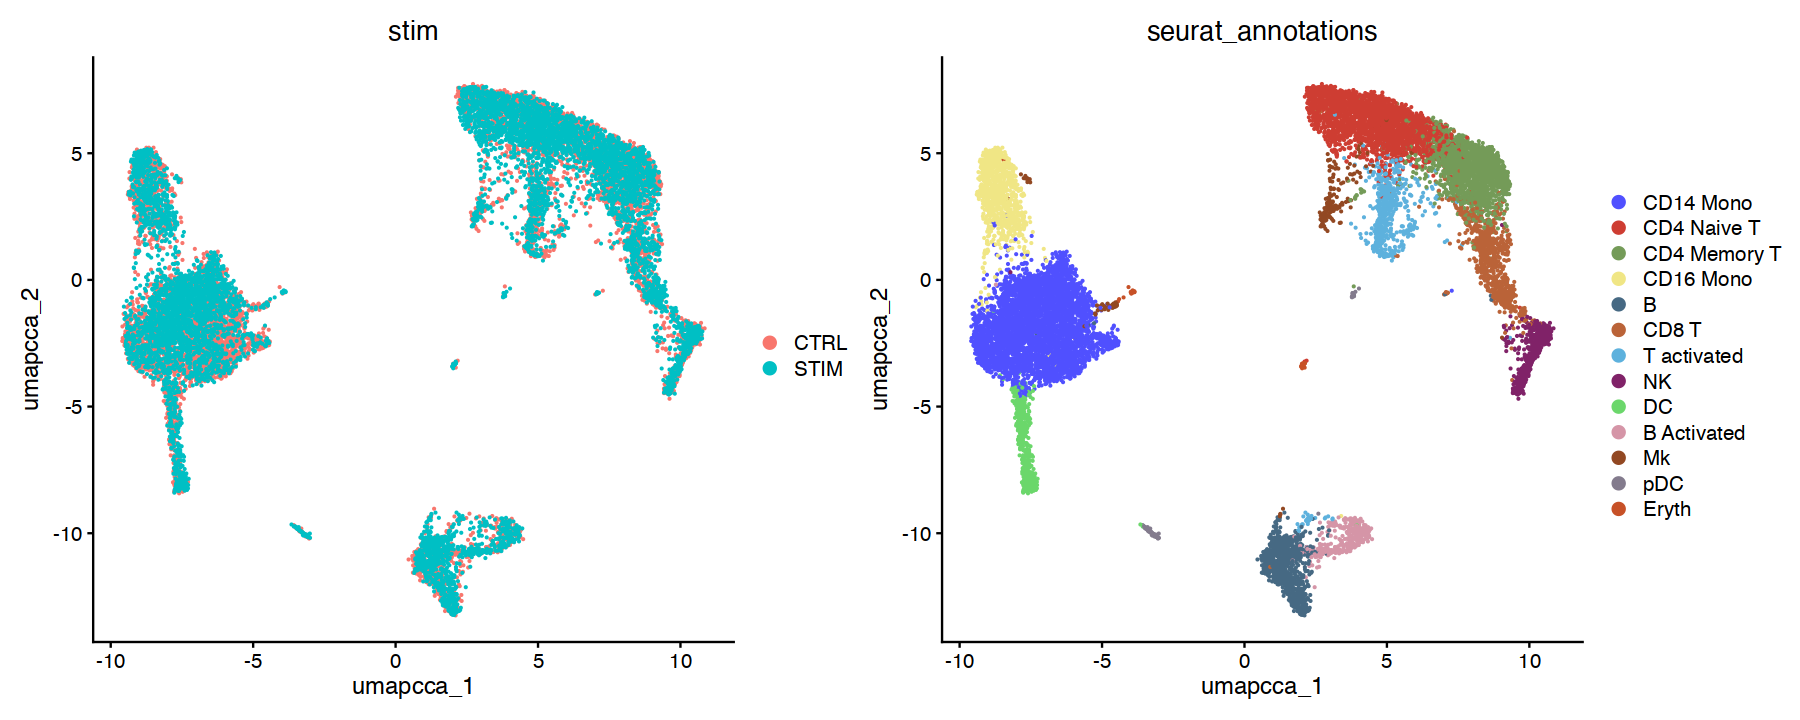

In [26]:
DimPlot(ifnb, reduction = "umap.cca", group.by = c("stim", "seurat_annotations")) + scale_color_igv()

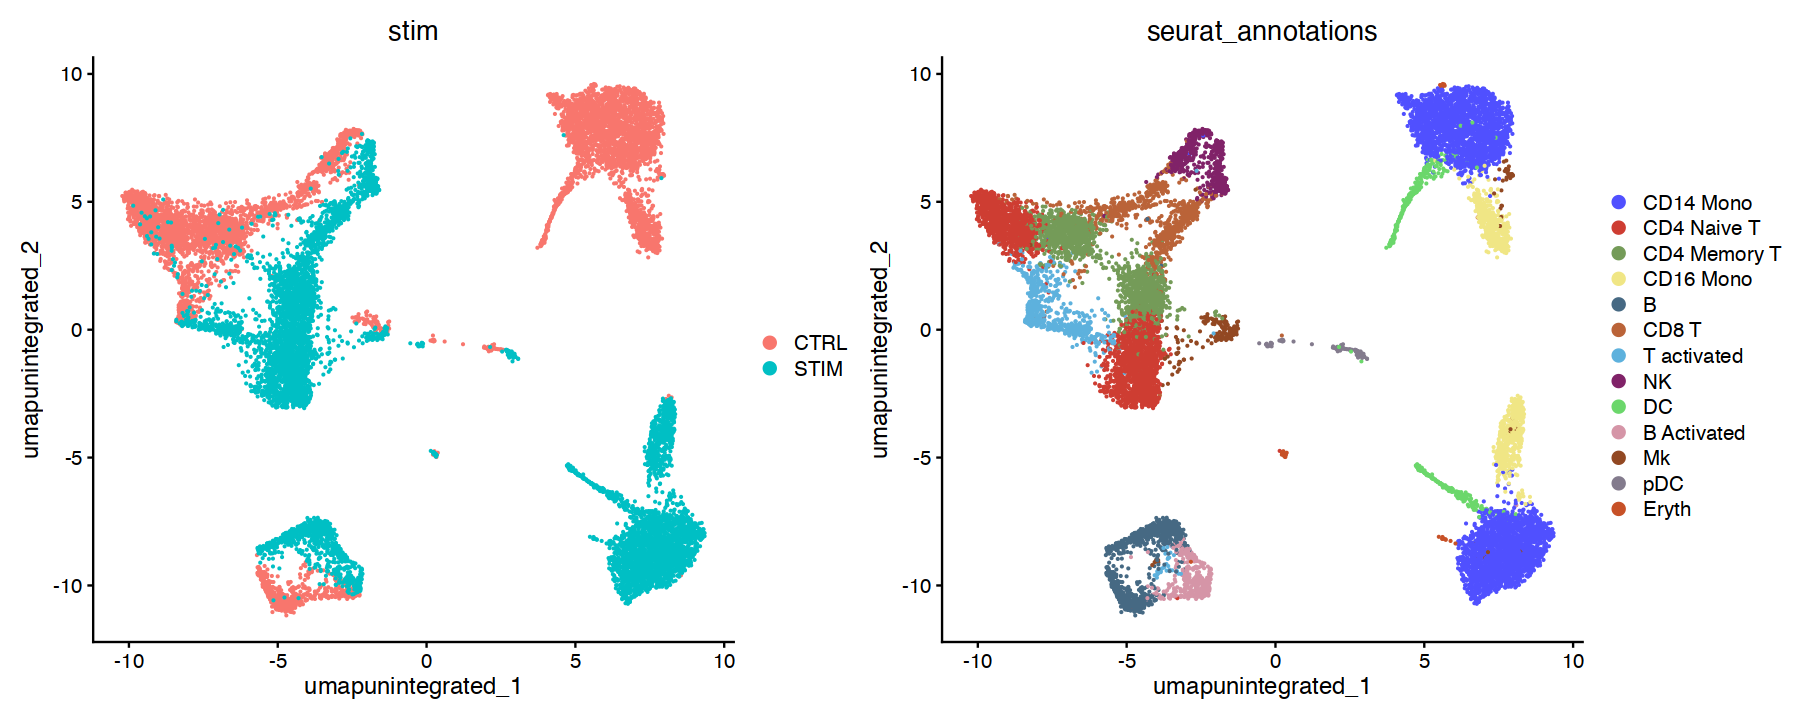

In [27]:
DimPlot(ifnb, reduction = "umap.unintegrated", group.by = c("stim", "seurat_annotations")) + scale_color_igv()

In [28]:
# re-join layers after integration
#ifnb[["RNA"]] <- JoinLayers(ifnb[["RNA"]])

In [29]:
#Idents(ifnb) <- "seurat_annotations"
#nk.markers <- FindMarkers(ifnb, ident.1 = "NK", grouping.var = "stim", verbose = FALSE)
#head(nk.markers)